# Highlighting custom SMARTS pattern in user-drawn molecule
---

General usage
1. Load the JSME editor and draw the molecule of interest
2. Upload the csv file containing the SMARTS pattern of your custom chemical filters.
3. Highlight the SMARTS pattern in the molecule drawn by the user.

Majority of the code is taken from the following resources:
1. <a href="https://github.com/lithium0003/JSME_ipywidget">JSME_ipywidget</a>
2. "T003_compound_unwanted_substructures" of <a href="https://github.com/volkamerlab/teachopencadd">TeachOpenCADD</a> 

Reference:
1. (a)<a bref="https://jsme-editor.github.io/">JSME editor</a> (b) <a href="https://github.com/lithium0003/JSME_ipywidget">JSME_ipywidget for jupyter notebook</a>
2. <a href="https://www.rdkit.org">RDKit official website</a>
3. teachopencadd talktorials (a) <a href="https://doi.org/10.1093/nar/gkac267">Publication</a>, (b) <a href="https://projects.volkamerlab.org/teachopencadd/">website</a>, (c) <a href="https://github.com/volkamerlab/teachopencadd">Github </a>
4. <a href="https://doi.org/10.1002/cmdc.200700139">The Brenk filter.</a> Actually its already implemented in RDKit, using it to test the use of custom filters.


---

## Import useful tools

Load the tools for analyzing your molecule.

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import io
import ipywidgets
from ipywidgets import FileUpload
from IPython.display import display

Load the JSME widget.

In [2]:
from traitlets import Unicode, Bool, validate, TraitError
from ipywidgets import DOMWidget, register

@register
class SmilesEditor(DOMWidget):
    _view_name = Unicode('SmilesView').tag(sync=True)
    _view_module = Unicode('smiles_widget').tag(sync=True)
    _view_module_version = Unicode('0.1.0').tag(sync=True)

    # Attributes
    smiles = Unicode('', help="SMILES value").tag(sync=True)
    mol = Unicode('', help="mol value").tag(sync=True)
    
    def __init__(self, *pargs, **kwargs):
        init_struct = {}
        if 'smiles' in kwargs:
            init_struct['smiles'] = kwargs.pop('smiles')
        if 'mol' in kwargs:
            init_struct['mol'] = kwargs.pop('mol')
        super().__init__(*pargs, **kwargs)
        self.smiles = init_struct.get('smiles','')
        self.mol = init_struct.get('mol','')

In [3]:
%%javascript
require.undef('smiles_widget');
require(['jsme/jsme.nocache.js'])
define('smiles_widget', ["@jupyter-widgets/base"], function(widgets) {
    var SmilesView = widgets.DOMWidgetView.extend({
        // Render the view.
        render: function() {
            this.smiles_input = document.createElement('div');
            this.smiles_input.id = "jsme_container";
            this.smiles_display = document.createElement('div');
            this.smiles_display.textContent="SMILES : ";
            this.el.appendChild(this.smiles_display);
            this.el.appendChild(this.smiles_input);
            
            this.changeFunc = function(jsme) {
                let smiles = jsme.smiles();
                let mol = jsme.molFile();
                this.smiles_display.textContent="SMILES : "+smiles;
                this.model.set('smiles', smiles);
                this.model.set('mol', mol);
                this.model.save_changes();                
            };
            
            function myFunc(callback, widget){
                var param = {};
                if (widget.model.get('smiles')) {
                    param = {"smiles" : widget.model.get('smiles')};
                }
                if(widget.model.get('mol')) {
                    param = {"mol" : widget.model.get('mol')};                    
                }
                let jsmeApplet = new JSApplet.JSME("jsme_container", "480px", "480px",  param);
                jsmeApplet.setCallBack("AfterStructureModified", callback);
                widget.changeFunc(jsmeApplet);
            };
            setTimeout(myFunc, 500, this.smilesChanged.bind(this), this);
        },

        smilesChanged: function(jsmeEvent) {
            let jsme = jsmeEvent.src;
            this.changeFunc(jsme);
        },
    });
    return {
        SmilesView: SmilesView
    };
});

<IPython.core.display.Javascript object>

# Run the JSME editor

Run the next cell to start the editor. Draw the molecule after loading.

In [4]:
editor = SmilesEditor()
editor

SmilesEditor()

Print the SMILES string of the molecule you draw.

In [5]:
print(editor.smiles)

C/N=N/C(=O)C#N


Run the following cell to get the upload button. Once you see the upload button, upload the file with your custom filters. I am using the <a href="https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T003_compound_unwanted_substructures/data/unwanted_substructures.csv">Brenk filters in a csv file taken from the 3rd talktorials of TeachOpenCADD</a> to test this notebook. Please use the same format in your custom filter file.

In [6]:
uploader = FileUpload(multiple=False)

display(uploader)

FileUpload(value={}, description='Upload')

After you have uploaded the file with custom chemical filters, run the next cell.

In [7]:
uploaded_file = uploader.data[0]
substructures = pd.read_csv(io.BytesIO(uploaded_file), sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))

Number of unwanted substructures in collection: 104


# Search for unwanted substructure in your molecule

In [8]:
# search for unwanted substructure
matches = []
clean = []

mol = Chem.MolFromSmiles(editor.smiles)
match = False
for _, substructure in substructures.iterrows():
    if mol.HasSubstructMatch(substructure.rdkit_molecule):
        matches.append(
            {
                "rdkit_molecule": mol,
                "substructure": substructure.rdkit_molecule,
                "substructure_name": substructure["name"],
            }
        )
        match = True

matches = pd.DataFrame(matches)

print(f"Number of found unwanted substructure: {len(matches)}")

Number of found unwanted substructure: 2


# Highlight matching substructures in the user-drawn molecule

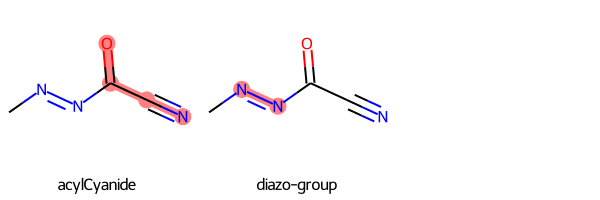

In [9]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(10).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)